In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import mlflow
import os

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_squared_error
from src.utils import get_metrics

from presentation.pipelines.steps.model_design import load_pt_model, build_classifier
from presentation.pipelines.steps.load_data import build_loader 


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

2024-05-04 17:35:40.770047: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
root = './presentation/results/zero/2024-04-24_16-13-23/'
adam_op = Adam(1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9, 
               clipvalue=1e-4)
astromer, config = load_pt_model(os.path.join(root, 'pretraining'), optimizer=adam_op)
pd.DataFrame([config])[['data', 'arch', 'lr', 'probed', 'rs', 'same', 'mask_format', 'm_alpha']]

[INFO] Zero architecture loaded
[INFO] Using masked-att with alpha = 1.00
[INFO] Using masked-att with alpha = 1.00
[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens


,data,arch,lr,probed,rs,same,mask_format,m_alpha
0,./data/records/macho/,zero,0.001,0.5,0.2,0.2,QK,1.0


## Loading downstream data

In [5]:
data_path = './data/records/alcock/fold_0/alcock_100/'
loaders = build_loader(data_path, 
                       config, 
                       batch_size=32,
                       clf_mode=False,
                       sampling=False,
                       normalize='zero-mean')

[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Zero
[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Zero
[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Zero


In [6]:
test_loss, test_r2, test_rmse = astromer.evaluate(loaders['test'].take(10))

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['mask_out'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens
10/10 [==============================] - 2s 98ms/step - loss: 0.0809 - r_square: 0.7352 - rmse: 0.0809


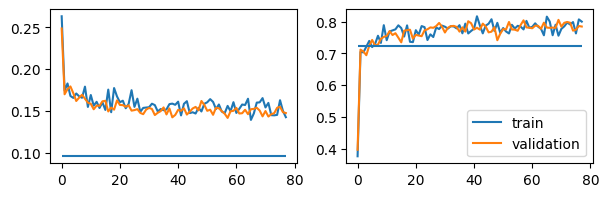

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(7, 2))
for sset in ['train', 'validation']:
    m = get_metrics(os.path.join(root, 'pretraining', 'tensorboard', sset)) 
    axes[0].plot(m['step'], m['value'])
    m = get_metrics(os.path.join(root, 'pretraining', 'tensorboard', sset), metric_name='epoch_r_square') 
    axes[1].plot(m['step'], m['value'], label=sset)

axes[0].hlines(test_loss, 0, m['step'].max())
axes[1].hlines(test_r2, 0, m['step'].max())
plt.legend()
plt.show()

## Finetuning

In [8]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

In [9]:
hist = astromer.fit(loaders['train'], epochs=10000, validation_data=loaders['validation'], 
             callbacks=[EarlyStopping(monitor='val_loss', patience=20)])

Epoch 1/10000
[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens
[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens
62/62 [==============================] - 14s 199ms/step - loss: 0.1033 - r_square: 0.7589 - rmse: 0.1033 - val_loss: 0.0786 - val_r_square: 0.9755 - val_rmse: 0.0786
Epoch 2/10000
62/62 [==============================] - 12s 201ms/step - loss: 0.0970 - r_square: 0.7840 - rmse: 0.0970 - val_loss: 0.0983 - val_r_square: 0.9613 - val_rmse: 0.0983
Epoch 3/10000
62/62 [==============================] - 12s 195ms/step - loss: 0.0947 - r_square: 0.7865 - rmse: 0.0947 - val_loss: 0.0634 - val_r_square: 0.8434 - val_rmse: 0.0634
Epoch 4/10000
62/62 [==============================] - 12s 201ms/step - loss: 0.1020 - r_square: 0.7754 - rmse: 0.1020 - val_loss: 0.0652 - val_r_square: 0.8553 - val_rmse: 0.0652
Epoch 5/10000
62/62 [==============================] - 13s 203ms/step - loss: 0.

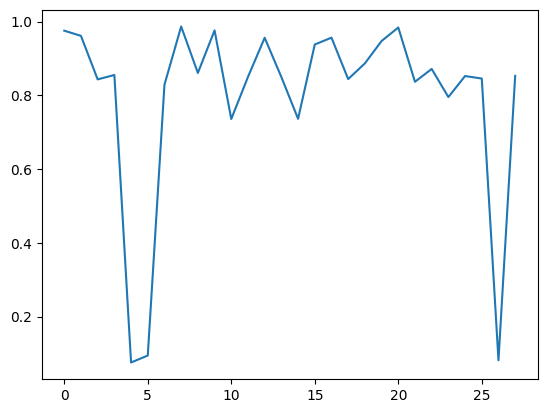

In [10]:
plt.plot(hist.history['val_r_square'])

In [10]:
test_loss, test_r2, test_rmse = astromer.evaluate(loaders['test'].take(10))

10/10 [==============================] - 1s 65ms/step - loss: 0.0881 - r_square: 0.6883 - rmse: 0.0881


In [11]:
astromer.save_weights(os.path.join(root, 'ft_new', 'weights'))

## Classification

In [14]:
loaders = build_loader(data_path, 
                       config, 
                       batch_size=32,
                       clf_mode=True,
                       sampling=False,
                       normalize='zero-mean')

Classification Mode
[INFO] Probed: 1.00 Random: 0.00 Same: 0.00
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Zero
[INFO] Probed: 1.00 Random: 0.00 Same: 0.00
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Zero
[INFO] Probed: 1.00 Random: 0.00 Same: 0.00
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Zero


In [ ]:
build_classifier(astromer, params, astromer_trainable, num_cls=None, arch='avg_mlp')